In [1]:
!pip install torch torchvision torchaudio


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
random_int8 = torch.randint(-128, 127, (32, 16)).to(torch.int8)
random_hs = torch.randn((1, 16), dtype=torch.bfloat16)
scales = torch.randn((1, 32), dtype=torch.bfloat16)
bias = torch.randn((1, 32), dtype=torch.bfloat16)

In [4]:
F.linear(random_hs, random_int8.to(random_hs.dtype))

tensor([[ 148.0000,   35.0000,  460.0000,  472.0000, -146.0000,  145.0000,
          163.0000,  -16.0000,  -57.5000,  -50.0000,  158.0000, -152.0000,
          496.0000,   56.2500, -145.0000,    1.4219,  394.0000,  736.0000,
         -286.0000,  528.0000, -628.0000, -202.0000,  -44.2500,  108.0000,
          186.0000,  352.0000,  596.0000, -217.0000,  788.0000, -120.0000,
         -624.0000,  428.0000]], dtype=torch.bfloat16)

In [5]:
F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales

tensor([[-1.1050e+02,  4.3500e+01, -6.6400e+02, -4.8600e+02,  6.4500e+01,
          6.6562e+00, -2.4250e+01, -6.4062e-01, -7.2500e+01, -5.3500e+01,
          2.1750e+01,  1.8300e+02,  3.1000e+02,  1.4812e+01,  1.1850e+02,
          5.5469e-01, -2.3500e+02,  5.2800e+02,  3.0200e+02,  3.7000e+02,
          5.0250e+01, -2.8000e+02,  2.9250e+01, -9.0500e+01, -5.0938e+00,
         -1.8300e+02,  4.6800e+02,  4.5800e+02, -4.1600e+02, -6.8500e+01,
         -6.4400e+02, -1.1550e+02]], dtype=torch.bfloat16)

In [6]:
(F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales) + bias

tensor([[-1.1150e+02,  4.3750e+01, -6.6000e+02, -4.8600e+02,  6.3750e+01,
          8.1875e+00, -2.3875e+01,  1.6797e-01, -7.2000e+01, -5.4750e+01,
          2.3250e+01,  1.8400e+02,  3.1200e+02,  1.4688e+01,  1.1750e+02,
          1.2188e+00, -2.3500e+02,  5.2800e+02,  3.0400e+02,  3.6800e+02,
          4.9250e+01, -2.8000e+02,  3.0875e+01, -8.9500e+01, -4.9375e+00,
         -1.8300e+02,  4.7000e+02,  4.5800e+02, -4.1600e+02, -7.0000e+01,
         -6.4400e+02, -1.1650e+02]], dtype=torch.bfloat16)

In [7]:
def w8_a16_forward(weight, input, scales, bias=None):

    casted_weights = weight.to(input.dtype)
    output = F.linear(input, casted_weights) * scales

    if bias is not None:
        output = output + bias

    return output

In [8]:
print("With bias:\n\n",
      w8_a16_forward(random_int8, random_hs, scales, bias))

print("\nWithout bias:\n\n",
      w8_a16_forward(random_int8, random_hs, scales))

With bias:

 tensor([[-1.1150e+02,  4.3750e+01, -6.6000e+02, -4.8600e+02,  6.3750e+01,
          8.1875e+00, -2.3875e+01,  1.6797e-01, -7.2000e+01, -5.4750e+01,
          2.3250e+01,  1.8400e+02,  3.1200e+02,  1.4688e+01,  1.1750e+02,
          1.2188e+00, -2.3500e+02,  5.2800e+02,  3.0400e+02,  3.6800e+02,
          4.9250e+01, -2.8000e+02,  3.0875e+01, -8.9500e+01, -4.9375e+00,
         -1.8300e+02,  4.7000e+02,  4.5800e+02, -4.1600e+02, -7.0000e+01,
         -6.4400e+02, -1.1650e+02]], dtype=torch.bfloat16)

Without bias:

 tensor([[-1.1050e+02,  4.3500e+01, -6.6400e+02, -4.8600e+02,  6.4500e+01,
          6.6562e+00, -2.4250e+01, -6.4062e-01, -7.2500e+01, -5.3500e+01,
          2.1750e+01,  1.8300e+02,  3.1000e+02,  1.4812e+01,  1.1850e+02,
          5.5469e-01, -2.3500e+02,  5.2800e+02,  3.0200e+02,  3.7000e+02,
          5.0250e+01, -2.8000e+02,  2.9250e+01, -9.0500e+01, -5.0938e+00,
         -1.8300e+02,  4.6800e+02,  4.5800e+02, -4.1600e+02, -6.8500e+01,
         -6.4400e+02, -

In [9]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features,
                 bias=True, dtype=torch.float32):
        super().__init__()


        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )

        self.register_buffer("scales",
                             torch.randn((out_features), dtype=dtype))

        if bias:
            self.register_buffer("bias",
                                 torch.randn((1, out_features),
                                             dtype=dtype))

        else:
            self.bias = None

In [10]:
dummy_instance = W8A16LinearLayer(16, 32)

In [11]:
print(dummy_instance.int8_weights.shape)
print(dummy_instance.scales.shape)

torch.Size([32, 16])
torch.Size([32])


In [20]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features,
                 bias=True, dtype=torch.float32):
        super().__init__()


        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )

        self.register_buffer("scales",
                             torch.randn((out_features), dtype=dtype))

        if bias:
            self.register_buffer("bias",
                                 torch.randn((1, out_features),
                                             dtype=dtype))

        else:
            self.bias = None

    def forward(self, input):
        return w8_a16_forward(self.int8_weights,
                              input, self.scales, self.bias)

In [21]:
module = W8A16LinearLayer(16, 32)
dummy_hidden_states = torch.randn(1, 6, 16)

In [22]:
module = W8A16LinearLayer(16, 32)
dummy_hidden_states = torch.randn(1, 6, 16)

In [23]:
module(dummy_hidden_states).shape

torch.Size([1, 6, 32])

In [24]:
module(dummy_hidden_states).dtype

torch.float32

quantize Function of class W8A16LinearLayer¶
quantize function will dynamically quantize half-precision weights into torch.int8

In [25]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features,
                 bias=True, dtype=torch.float32):
        super().__init__()


        self.register_buffer(
            "int8_weights",
            torch.randint(
                -128, 127, (out_features, in_features), dtype=torch.int8
            )
        )

        self.register_buffer("scales",
                             torch.randn((out_features), dtype=dtype))

        if bias:
            self.register_buffer("bias",
                                 torch.randn((1, out_features),
                                             dtype=dtype))

        else:
            self.bias = None

    def quantize(self, weights):
        w_fp32 = weights.clone().to(torch.float32)

        scales = w_fp32.abs().max(dim=-1).values / 127
        scales = scales.to(weights.dtype)

        int8_weights = torch.round(weights
                        /scales.unsqueeze(1)).to(torch.int8)

        self.int8_weights = int8_weights
        self.scales = scales

    def forward(self, input):
        return w8_a16_forward(self.int8_weights,
                              input, self.scales, self.bias)

In [26]:
module = W8A16LinearLayer(4, 8)

In [27]:
print("Weights before:\n" , module.int8_weights)

Weights before:
 tensor([[-128,   78, -110,  -44],
        [   8,   86,   -2,    5],
        [-100,  -10,  103,  -97],
        [   6,  -52,  115,  -90],
        [ -88,  -88,   46,  -24],
        [ -29, -110,   48,   93],
        [ -50,  -85,  -28,   37],
        [-123,   64,  109,   25]], dtype=torch.int8)


In [28]:
random_matrix = torch.randn((4, 8), dtype=torch.bfloat16)

In [30]:
module.quantize(random_matrix)

In [31]:
print("Weights After:\n" , module.int8_weights)

Weights After:
 tensor([[ -16,   15,  -83,   76,    3,  127,  -44,   19],
        [-128,   59, -120, -124, -110,   13,    9,  -10],
        [  61,  -40,   65,   97,    7,  -52,  127,  -56],
        [  49,  -94,   47,  -54,  127,  -40,   46,  -52]], dtype=torch.int8)


In [32]:
module.scales

tensor([0.0152, 0.0110, 0.0159, 0.0179], dtype=torch.bfloat16)

In [33]:
module.scales.shape

torch.Size([4])

In [34]:
module.int8_weights.shape

torch.Size([4, 8])

In [35]:
### dequantized weights
module.int8_weights * module.scales.unsqueeze(1)

tensor([[-0.2432,  0.2275, -1.2578,  1.1562,  0.0457,  1.9297, -0.6680,  0.2891],
        [-1.4141,  0.6523, -1.3281, -1.3672, -1.2188,  0.1436,  0.0996, -0.1104],
        [ 0.9688, -0.6328,  1.0312,  1.5391,  0.1113, -0.8242,  2.0156, -0.8906],
        [ 0.8789, -1.6875,  0.8438, -0.9688,  2.2812, -0.7188,  0.8242, -0.9336]],
       dtype=torch.bfloat16)

In [36]:
### original weights
random_matrix

tensor([[-0.2441,  0.2324, -1.2578,  1.1484,  0.0459,  1.9297, -0.6758,  0.2891],
        [ 1.4062,  0.6484, -1.3281, -1.3750, -1.2188,  0.1426,  0.0967, -0.1143],
        [ 0.9688, -0.6445,  1.0312,  1.5391,  0.1079, -0.8320,  2.0156, -0.8828],
        [ 0.8750, -1.6797,  0.8438, -0.9727,  2.2812, -0.7227,  0.8320, -0.9297]],
       dtype=torch.bfloat16)

In [37]:
(random_matrix - module.int8_weights
 * module.scales.unsqueeze(1)).abs().mean()

tensor(0.0913, dtype=torch.bfloat16)

Linear Layer replacement

In [38]:
def replace_linear_with_target(module,
                               target_class, module_name_to_exclude):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and not \
          any([x == name for x in module_name_to_exclude]):
            old_bias = child.bias

            new_module = target_class(child.in_features,
                                      child.out_features,
                                      old_bias is not None,
                                      child.weight.dtype)
            setattr(module, name, new_module)
            if old_bias is not None:
              getattr(module, name).bias = old_bias
        else:
            # Recursively call the function for nested modules
            replace_linear_with_target(
                child, target_class, module_name_to_exclude)

In [39]:
class DummyModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.emb = torch.nn.Embedding(1, 1)
    # Try with bias
    self.linear_1 = nn.Linear(1, 1)
    # Try without bias
    self.linear_2 = nn.Linear(1, 1, bias=False)
    # Lm prediction head
    self.lm_head = nn.Linear(1, 1, bias=False)

In [40]:
model_1 = DummyModel()
model_2 = DummyModel()

In [41]:
replace_linear_with_target(model_1, W8A16LinearLayer, ["lm_head"])
print(model_1)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): W8A16LinearLayer()
  (linear_2): W8A16LinearLayer()
  (lm_head): Linear(in_features=1, out_features=1, bias=False)
)


In [42]:
replace_linear_with_target(model_2, W8A16LinearLayer, [])
print(model_2)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): W8A16LinearLayer()
  (linear_2): W8A16LinearLayer()
  (lm_head): W8A16LinearLayer()
)


Linear Layer Replacement +
Quantization

In [43]:
def replace_linear_with_target_and_quantize(module,
                               target_class, module_name_to_exclude):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and not \
        any([x == name for x in module_name_to_exclude]):
            old_bias = child.bias
            old_weight = child.weight

            new_module = target_class(child.in_features,
                                      child.out_features,
                                      old_bias is not None,
                                      child.weight.dtype)
            setattr(module, name, new_module)

            getattr(module, name).quantize(old_weight)

            if old_bias is not None:
              getattr(module, name).bias = old_bias
        else:
            # Recursively call the function for nested modules
            replace_linear_with_target_and_quantize(child,
                     target_class, module_name_to_exclude)

In [44]:
model_3 = DummyModel()

In [45]:
replace_linear_with_target_and_quantize(model_3, W8A16LinearLayer, ["lm_head"])
print(model_3)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): W8A16LinearLayer()
  (linear_2): W8A16LinearLayer()
  (lm_head): Linear(in_features=1, out_features=1, bias=False)
)


NOW LETS TEST ON A REAL LLM

In [47]:
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.60k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [48]:
previous_memory_footprint = model.get_memory_footprint()

In [49]:
print("Footprint of the model in MBs: ",
      previous_memory_footprint/1e+6)

Footprint of the model in MBs:  166.524032


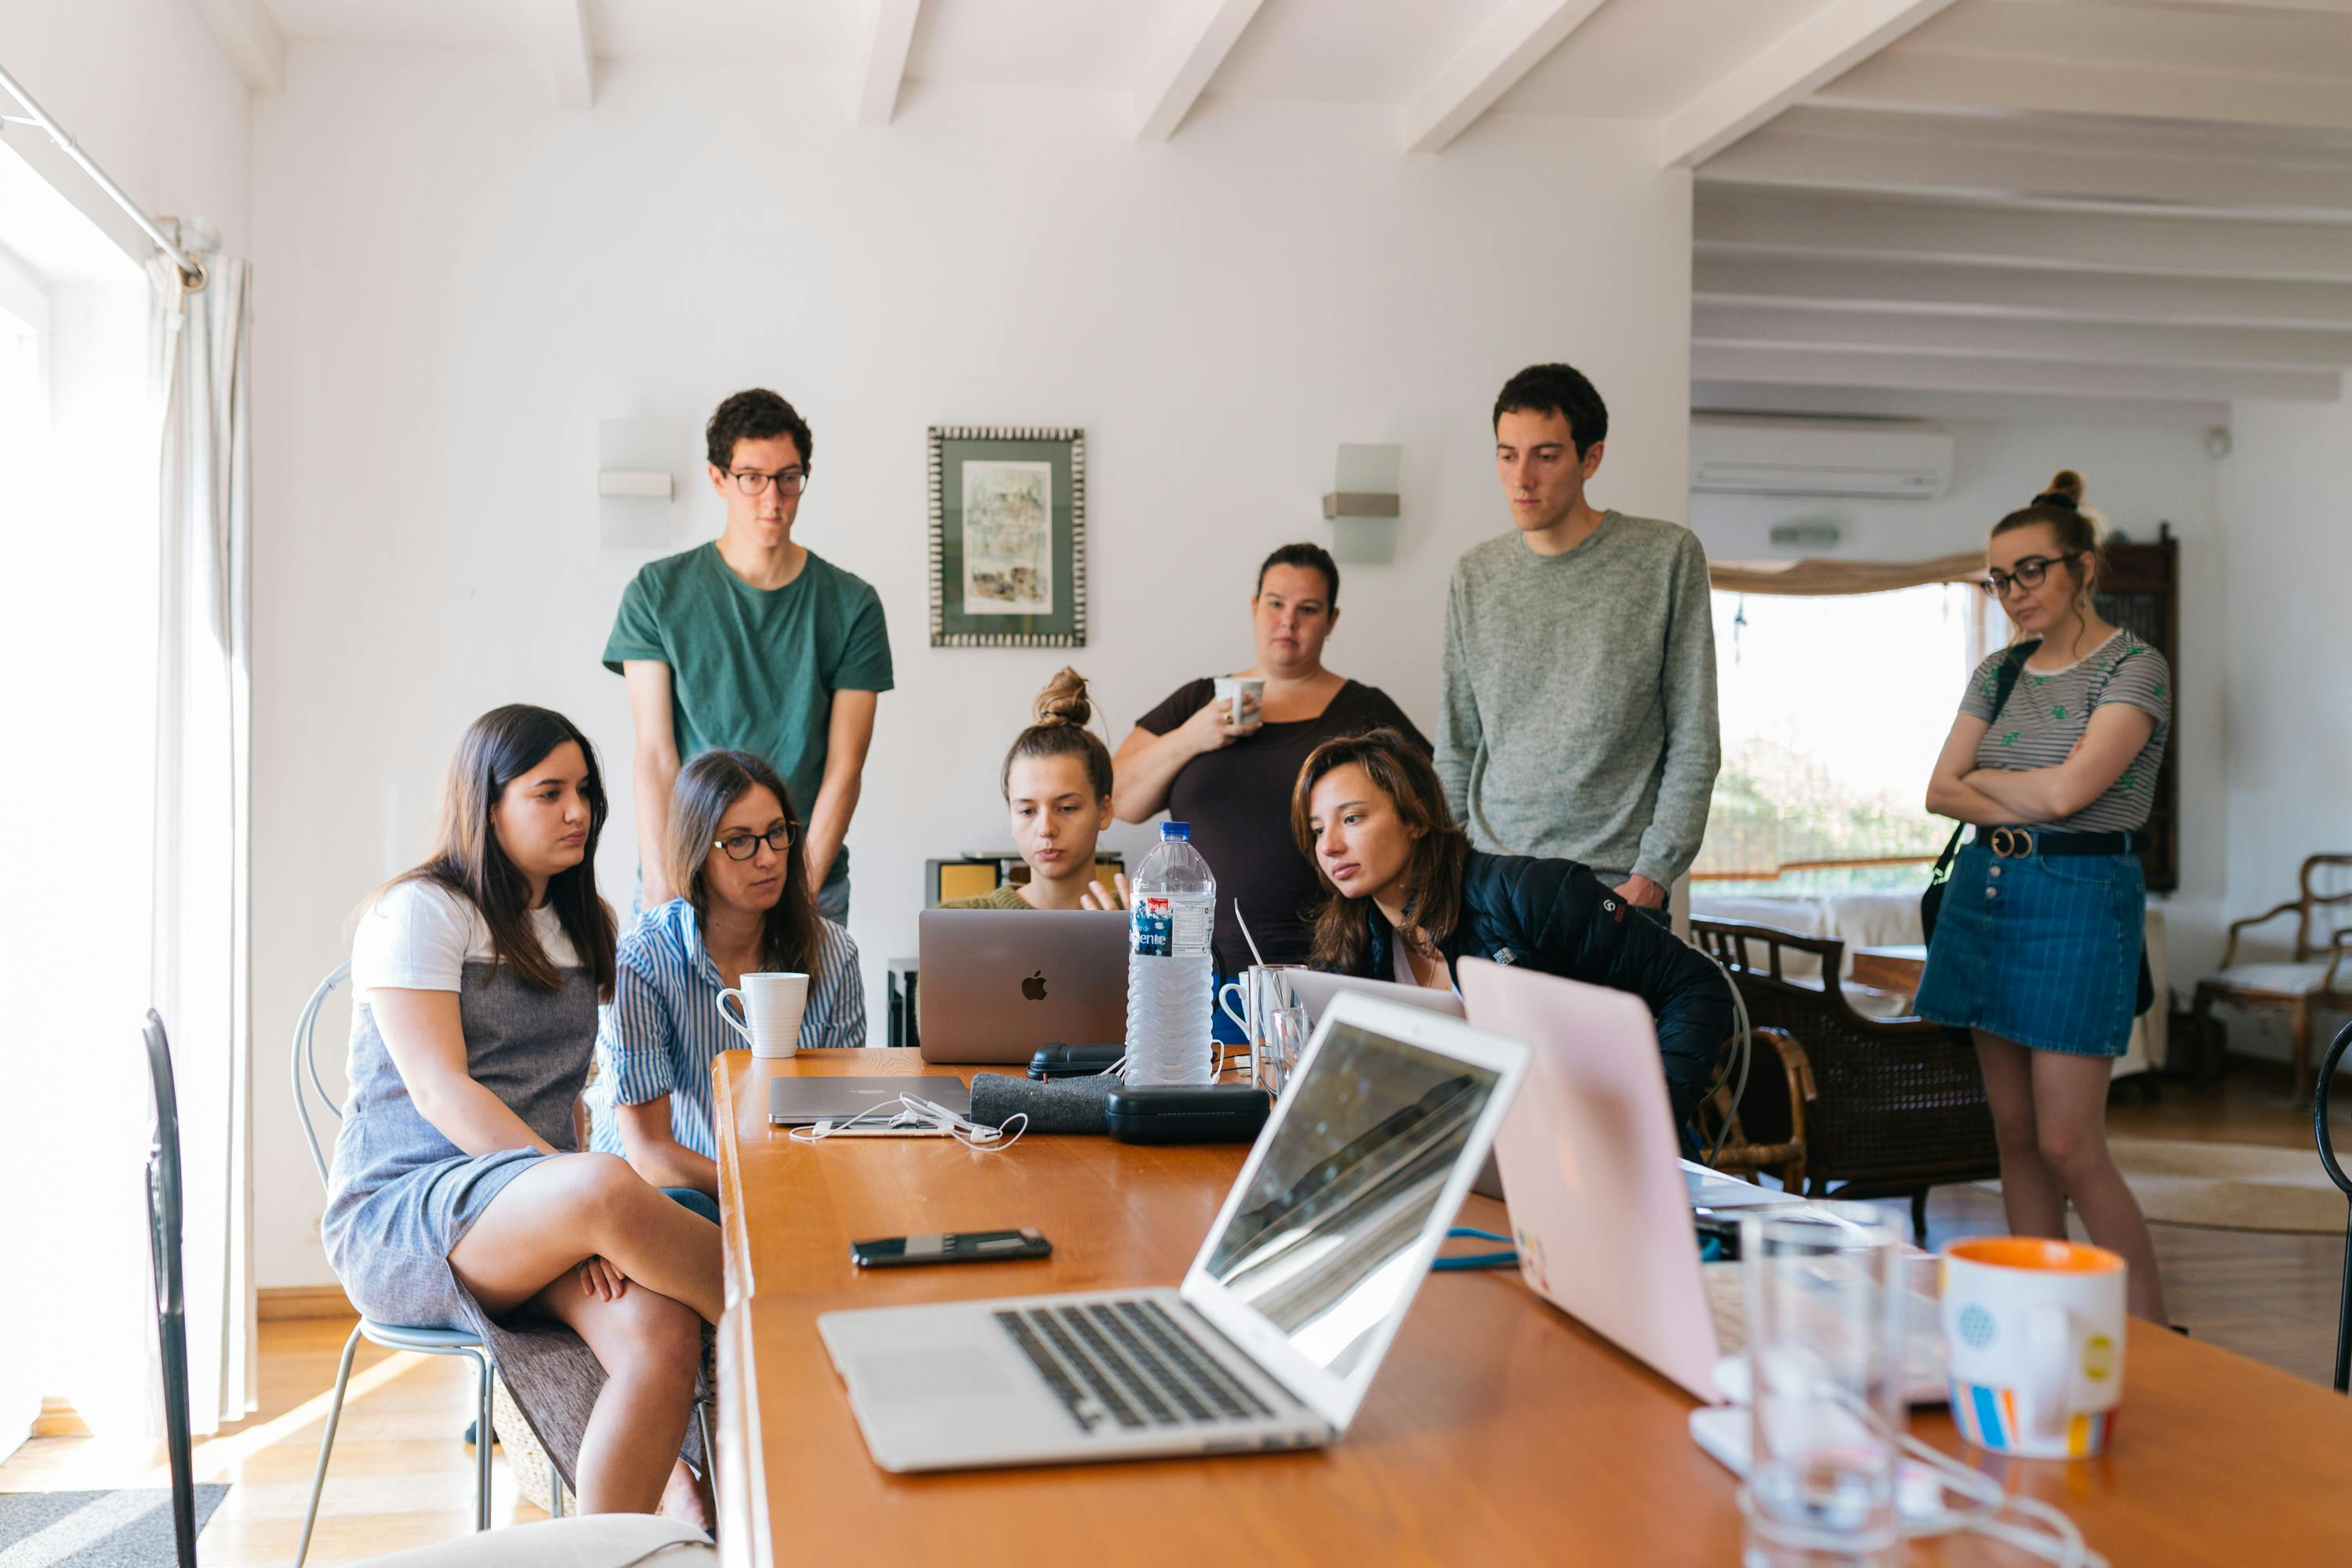

In [51]:
img_path = "/content/teams.jpg"
image = Image.open(img_path).convert("RGB")
image

In [ ]:
from quantizer.helper import plot_results

inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

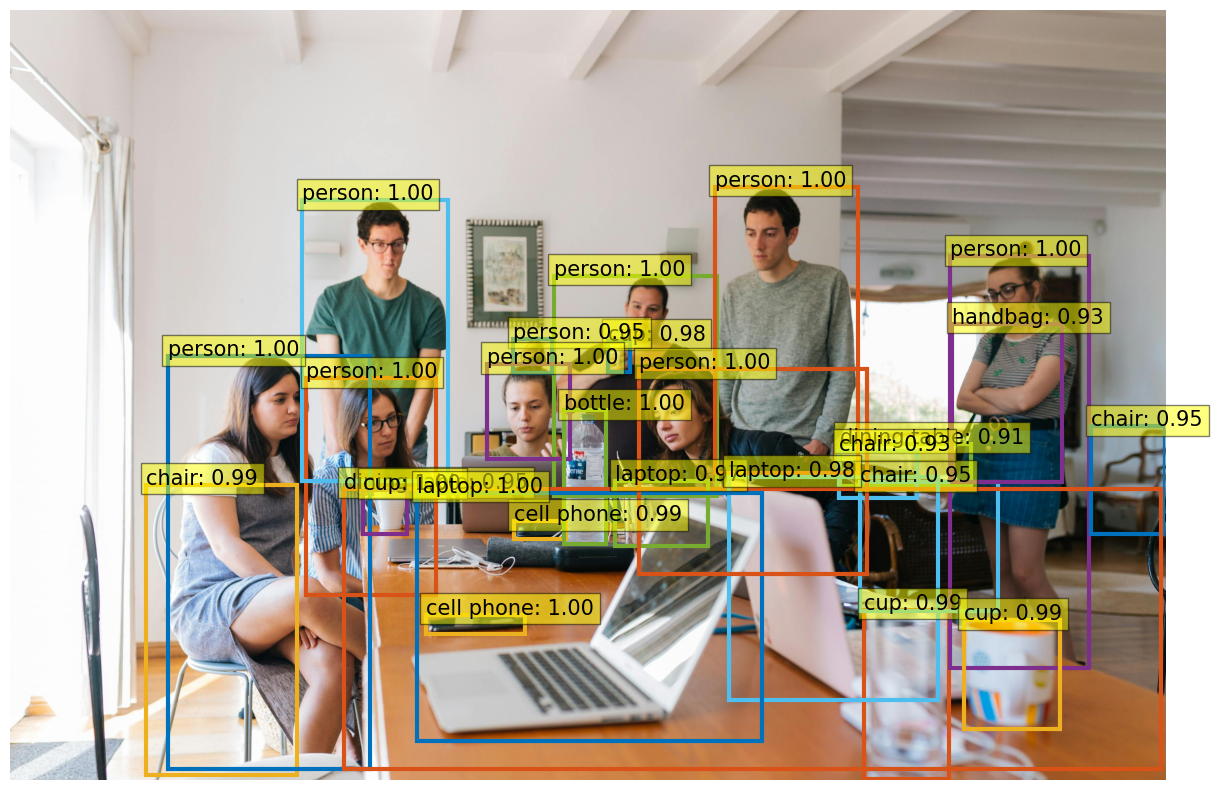

In [57]:
plot_results(model, image, results)

In [58]:
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [59]:
replace_linear_with_target_and_quantize(model,
                                        W8A16LinearLayer,
               ["0", "1", "2", "class_labels_classifier"])

In [60]:
### Model after quantization
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [61]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

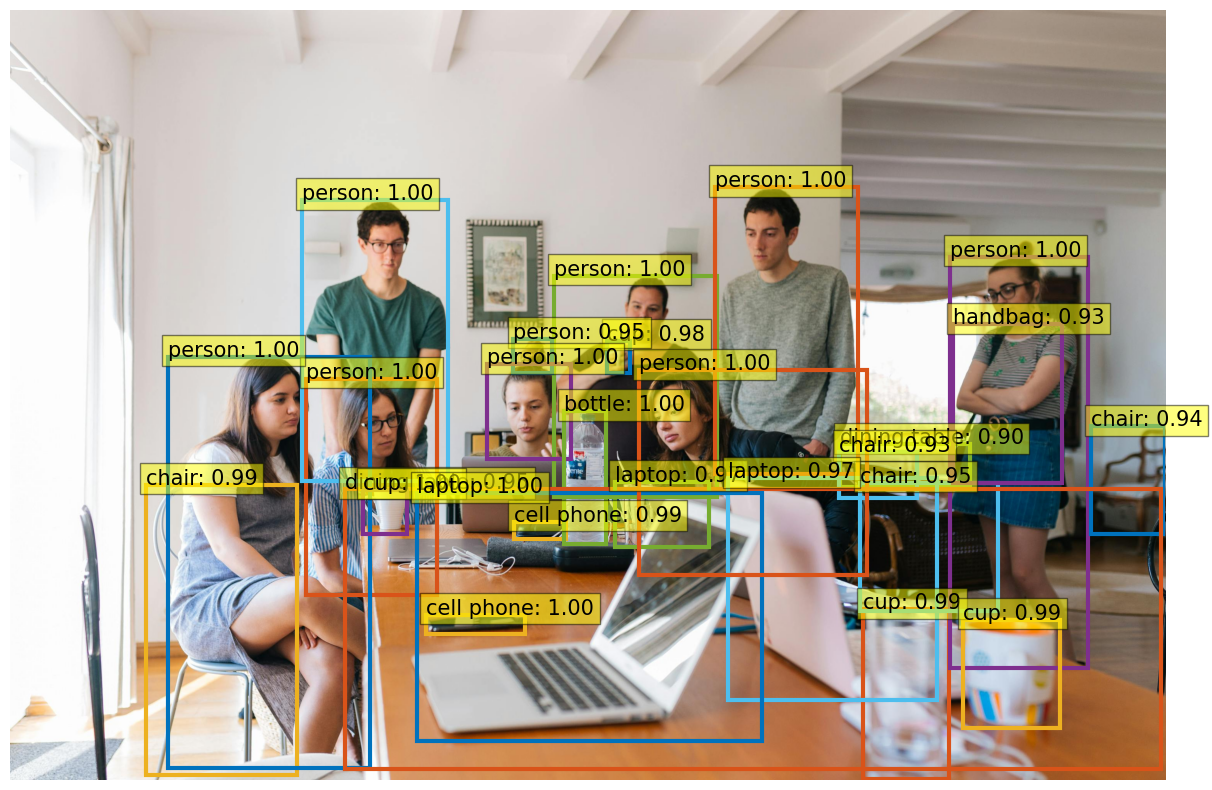

In [62]:
plot_results(model, image, results)

In [63]:
new_footprint = model.get_memory_footprint()

In [64]:
print("Footprint of the model in MBs: ",
      new_footprint/1e+6)

Footprint of the model in MBs:  114.80384


In [65]:
### Memory saved
print("Memory saved in MBs: ",
      (previous_memory_footprint - new_footprint)/1e+6)

Memory saved in MBs:  51.720192
